In [1]:
from itertools import combinations
import re
from tqdm import tqdm
import pandas as pd
import xmltodict
import networkx as nx
import collections
import matplotlib.pyplot as plt
from unidecode import unidecode
import altair as alt
tqdm.pandas()

In [2]:
def extract_authors(dc):
    if type(dc) == list:
        result = [
            unidecode(i.get("#text").title().strip())
            for i in dc
            if i.get("#text") is not None and i.get("@scheme") != "institution"
        ]
        return [x for x in result if x != "And Others"]
    elif dc.get("#text") is not None and dc.get("@scheme") != "institution":
        return [unidecode(dc.get("#text").title().strip())]


def clean_name(name):
    if ', ' in name:
        lst = name.split(', ')
        lst = [item.split(' ')[0] for item in lst]
        return lst[1] + ' ' + lst[0]
    elif ',' in name:
        lst = name.split(',')
        lst = [item.split(' ')[0] for item in lst]
        return lst[1] + ' ' + lst[0]
    else:
        return name


def get_edges(auth_list):
    return list(combinations(auth_list, 2))

def extract_ids(dc):
    if type(dc) == list:
        return [
            i.get("#text").upper().strip()
            for i in dc
            if i.get("#text") is not None and i.get("@scheme") == "eric_accno"
        ][0]
    elif dc.get("#text") is not None and dc.get("@scheme") == "eric_accno":
        return dc.get("#text").upper().strip()
    
def extract_subject(dc):
    result = []
    for item in dc:
        if type(item) == collections.OrderedDict:
            result.append(unidecode(item.get("#text").title().strip()))
        elif type(item) == str:
            result.append(unidecode(item.title().strip()))
        else:
            result.append(unidecode(item.title().strip()))
    return result

In [3]:
df_all = []

for year in tqdm(range(1965, 2021)):
    file_name = "data/eric" + str(year)
    with open(file_name + ".xml", encoding="utf-8") as fd:
        dict = xmltodict.parse(fd.read())
    recs = [rec["metadata"] for rec in dict["records"]["record"]]
    df = pd.DataFrame(recs)
    df = df[df['dc:type'].notna()]
    df = df[df['eric:peer_reviewed'].notna()]
    df['type'] = [''.join(map(str, l)).lower() for l in df['dc:type']]
    df = df.loc[df['eric:peer_reviewed'] == 'T']
    # df = df[['ids', 'authors', 'edges', 'dc:type', 'dc:subject', 'eric:keywords', 'eric:keywords_geo', 'dc:title', 'eric:pageCount', 'dc:date', 'eric:dateAdded']]
    df_all.append(df)

df_all = pd.concat(df_all)

df_all = df_all.loc[(df_all['type'].str.contains("journal"))]
df_all["authors"] = df_all.apply(lambda row: extract_authors(row["dc:creator"]), axis=1)
df_all = df_all[df_all['authors'].notna()]
df_all['authors'] = df_all.apply(lambda row: [clean_name(item) for item in row['authors']], axis=1)
df_all['n_authors'] = df_all.apply(lambda row: len(row["authors"]), axis=1)
df_all["edges"] = df_all.apply(lambda row: get_edges(sorted(row["authors"])), axis=1)
df_all["ids"] = df_all.apply(lambda row: extract_ids(row["dc:identifier"]), axis=1)

df_all = df_all[df_all['dc:subject'].notna()]
df_all["subjects"] = df_all.apply(lambda row: extract_subject(row["dc:subject"]), axis=1)
df_all.loc[:, 'subject_top'] = df_all.subjects.map(lambda x: x[0])

df_all.info()

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [10:27<00:00, 11.21s/it]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 908417 entries, 17594 to 44897
Data columns (total 42 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   dcterms:accessRights       908417 non-null  object
 1   dc:subject                 908417 non-null  object
 2   dc:creator                 908417 non-null  object
 3   dc:type                    908417 non-null  object
 4   eric:keywords              398882 non-null  object
 5   eric:keywords_geo          301814 non-null  object
 6   eric:issn                  746289 non-null  object
 7   dc:language                905398 non-null  object
 8   dcterms:educationLevel     326980 non-null  object
 9   dc:description             907928 non-null  object
 10  dc:identifier              908417 non-null  object
 11  dc:title                   908417 non-null  object
 12  dc:source                  908417 non-null  object
 13  eric:citation              908372 non-nul

In [4]:
df_all.groupby(['eric:dateAdded'])['dcterms:educationLevel'].apply(lambda x: x.isnull().mean())
# df_all["dc:subject"].iloc[328615]
#df_all[['subjects', 'subject_top']].to_csv("subjects.csv", encoding='utf-8', index=False)

eric:dateAdded
1971    1.000000
1972    1.000000
1973    1.000000
1974    1.000000
1975    1.000000
1976    1.000000
1977    1.000000
1978    1.000000
1979    1.000000
1980    0.999933
1981    1.000000
1982    1.000000
1983    1.000000
1984    1.000000
1985    1.000000
1986    1.000000
1987    1.000000
1988    1.000000
1989    1.000000
1990    1.000000
1991    1.000000
1992    0.999933
1993    1.000000
1994    0.999529
1995    0.999582
1996    0.999814
1997    1.000000
1998    1.000000
1999    1.000000
2000    0.999944
2001    1.000000
2002    1.000000
2003    0.999885
2004    0.998445
2005    0.592437
2006    0.592186
2007    0.481067
2008    0.456899
2009    0.425032
2010    0.389724
2011    0.399492
2012    0.382241
2013    0.383530
2014    0.320045
2015    0.322835
2016    0.318968
2017    0.321002
2018    0.332780
2019    0.324133
2020    0.327627
Name: dcterms:educationLevel, dtype: float64

In [5]:
df_all['eric:dateAdded'].value_counts().sort_index()

1971       28
1972       42
1973       36
1974       34
1975      131
1976       96
1977       81
1978       28
1979     7996
1980    15008
1981    15090
1982    12408
1983    13565
1984    13707
1985    13415
1986    13360
1987    13475
1988    12683
1989    14852
1990    14224
1991    14467
1992    14889
1993    14683
1994    16970
1995    16748
1996    16117
1997    15988
1998    14482
1999    17212
2000    17873
2001    15852
2002    18485
2003    17449
2004     6432
2005    18775
2006    18837
2007    28125
2008    35104
2009    41251
2010    37039
2011    36226
2012    35059
2013    19696
2014    37226
2015    36610
2016    38587
2017    38305
2018    35528
2019    36991
2020    37152
Name: eric:dateAdded, dtype: int64

In [6]:
def generate_graph(df_local):

    node_list1 = df_local["authors"].tolist()
    node_list2 = [x for x in node_list1 if x is not None]  # remove none
    node_list3 = [item for sublist in node_list2 for item in sublist]
    node_list = list(set(node_list3))

    n_papers_per_author = len(node_list3)/len(node_list)
    
    edge_list1 = df_local["edges"].tolist()
    edge_list2 = [x for x in edge_list1 if x is not None]  # remove none
    edge_list = [item for sublist in edge_list2 for item in sublist]

    G = nx.Graph()
    G.add_nodes_from(node_list)
    G.add_edges_from(edge_list)
    return (G, n_papers_per_author)

In [7]:
# year by year (NOT cumulative)
list1 = []

for year in tqdm(range(1965, 2021)):
    
    df_local = df_all.loc[df_all['eric:dateAdded'] == str(year)]
    
    if len(df_local) == 0:
        continue
    
    result = generate_graph(df_local)
    G = result[0]
    n_authors = len(G)
    n_papers = len(df_local)
    
    n_authors_per_paper = df_local['n_authors'].mean()
    n_papers_per_author = result[1]
    
    n_collabs = nx.number_of_edges(G)
    n_isolates = nx.number_of_isolates(G)
    mean_collabs = 2 * G.number_of_edges() / float(G.number_of_nodes())
    
    G_largest_comp = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    largest_component = len(G_largest_comp)/len(G) 
    
    deg_assort = nx.degree_assortativity_coefficient(G)
    avg_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    
    list1.append((year, n_authors, n_papers, n_authors_per_paper, n_papers_per_author, n_collabs, n_isolates, mean_collabs, largest_component, deg_assort, avg_clustering, transitivity))

df_summary = pd.DataFrame(list1, columns = ["year", "n_authors", "n_papers", "n_authors_per_paper", "n_papers_per_author", "n_collabs", "n_isolates", "mean_collabs", "largest_component", "deg_assort", "avg_clustering", "transitivity"])
df_summary

 12%|██████████▍                                                                        | 7/56 [00:04<00:13,  3.54it/s]C:\Users\shrut\AppData\Roaming\Python\Python39\site-packages\networkx\algorithms\assortativity\correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)
100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [01:26<00:00,  1.55s/it]


,year,n_authors,n_papers,n_authors_per_paper,n_papers_per_author,n_collabs,n_isolates,mean_collabs,largest_component,deg_assort,avg_clustering,transitivity
0,1971,35,28,1.500000,1.200000,13,12,0.742857,0.114286,-0.213333,0.000000,0.000000
1,1972,58,42,1.428571,1.034483,18,22,0.620690,0.034483,NaN,0.000000,0.000000
2,1973,47,36,1.333333,1.021277,12,23,0.510638,0.042553,NaN,0.000000,0.000000
3,1974,47,34,1.441176,1.042553,15,17,0.638298,0.042553,NaN,0.000000,0.000000
4,1975,161,131,1.358779,1.105590,44,74,0.546584,0.018634,-0.023256,0.000000,0.000000
5,1976,120,96,1.375000,1.100000,35,54,0.583333,0.033333,-0.098039,0.000000,0.000000
6,1977,103,81,1.432099,1.126214,34,38,0.660194,0.029126,-0.096774,0.000000,0.000000
7,1978,34,28,1.357143,1.117647,10,14,0.588235,0.058824,NaN,0.000000,0.000000
8,1979,8860,7996,1.247624,1.125959,1914,5197,0.432054,0.000677,0.019945,0.000000,0.000000
9,1980,15717,15008,1.264725,1.207673,3797,8707,0.483171,0.000509,-0.026748,0.000148,0.004184


In [8]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_authors'
)

alt.Chart(...)

In [9]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_papers'
)

alt.Chart(...)

In [10]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_authors_per_paper'
)

alt.Chart(...)

In [11]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_papers_per_author'
)

alt.Chart(...)

In [12]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_collabs'
)

alt.Chart(...)

In [13]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='mean_collabs'
)

alt.Chart(...)

In [14]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='n_isolates'
)

alt.Chart(...)

In [15]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='largest_component'
)

alt.Chart(...)

In [16]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='deg_assort'
)

alt.Chart(...)

In [17]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='avg_clustering'
)

alt.Chart(...)

In [18]:
alt.Chart(df_summary).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='year',
    y='transitivity'
)

alt.Chart(...)

In [19]:
list1 = []

result = generate_graph(df_all)
G = result[0]
n_authors = len(G)
n_papers = len(df_all)

n_authors_per_paper = df_all['n_authors'].mean()
n_papers_per_author = result[1]

n_collabs = nx.number_of_edges(G)
n_isolates = nx.number_of_isolates(G)
mean_collabs = 2 * G.number_of_edges() / float(G.number_of_nodes())

G_largest_comp = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
largest_component = len(G_largest_comp)/len(G) 

deg_assort = nx.degree_assortativity_coefficient(G)
avg_clustering = nx.average_clustering(G)
transitivity = nx.transitivity(G)

list1.append((year, n_authors, n_papers, n_authors_per_paper, n_papers_per_author, n_collabs, n_isolates, mean_collabs, largest_component, deg_assort, avg_clustering, transitivity))

df_overall = pd.DataFrame(list1, columns = ["year", "n_authors", "n_papers", "n_authors_per_paper", "n_papers_per_author", "n_collabs", "n_isolates", "mean_collabs", "largest_component", "deg_assort", "avg_clustering", "transitivity"])
df_overall

,year,n_authors,n_papers,n_authors_per_paper,n_papers_per_author,n_collabs,n_isolates,mean_collabs,largest_component,deg_assort,avg_clustering,transitivity
0,2020,697445,908417,2.027529,2.640842,1545698,115526,4.432458,0.635168,0.210728,0.464084,0.302958


In [20]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 697445\nNumber of edges: 1545698\nAverage degree:   4.4325'

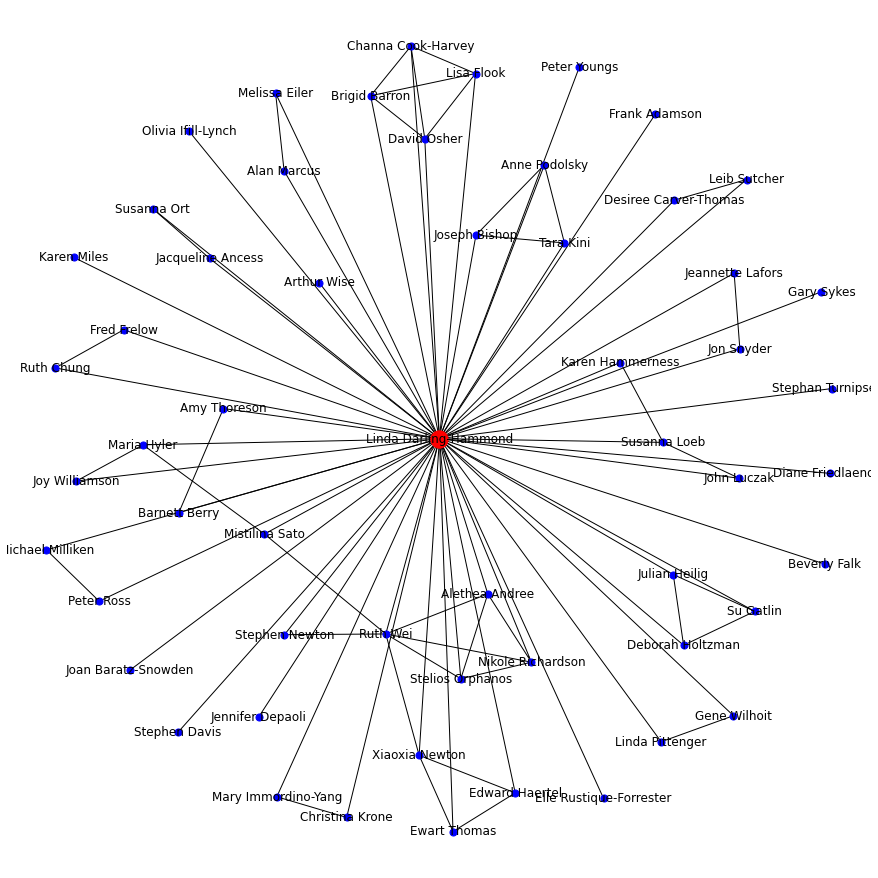

In [21]:
plt.figure(figsize=(12,12))

def draw_ego(name):
    hub_ego = nx.ego_graph(G, name)
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=True)
    options = {"node_size": 300, "node_color": "r"}
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[name], **options)

draw_ego("Linda Darling-Hammond")

In [ ]:
#df_summary.to_csv("df_summary.csv", encoding='utf-8', index=False)